In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

In [3]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/nuc-conc_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [4]:
trainXY = XY.sample(frac=0.5)
X, rY, cY, eY, bY, oY = splitXY(trainXY)
#X = scale(X)

In [5]:
trainXY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
6361,5772.23,4107.475813,5.14,s14x14,pwr,0.006929,1.6980,1.7030,0.000947,0.46710,1.2330,0.074060,0.002644,12.540,1.39500,0.312100,0.027530,0.020590,0.29740,0.14400
22093,19880.06,0.357616,2.17,svea100-0,bwr,0.045720,5.7960,5.5080,0.318700,1.58900,5.4210,0.377800,0.053970,14.150,4.29900,3.138000,0.879500,0.010640,1.12500,0.52680
20185,33048.14,0.000630,0.50,svea64-1,bwr,0.105700,9.5450,8.6860,0.749600,2.09400,8.8690,0.700800,0.105400,10.650,5.59400,3.392000,2.824000,0.006117,1.82500,0.83940
12300,12784.05,31.094272,4.40,ge8x8-1,bwr,0.025040,3.7320,3.6590,0.155900,1.17700,3.5030,0.217300,0.027420,15.230,3.16200,2.082000,0.301800,0.017800,0.71060,0.34110
3262,1805.64,7.209688,0.53,w15x15,pwr,0.000582,0.5497,0.5090,0.001777,0.11350,0.5057,0.014680,0.000376,2.634,0.10570,0.005991,0.000096,0.013420,0.07673,0.03669
15970,14626.44,450.099130,1.62,abb8x8-1,bwr,0.024810,4.3290,4.2240,0.107500,1.11400,3.9120,0.229300,0.024310,11.550,3.24400,1.492000,0.304900,0.014100,0.79460,0.40920
15951,12699.87,32.483539,1.62,abb8x8-1,bwr,0.019100,3.7710,3.6950,0.119400,0.97740,3.4970,0.186000,0.020200,11.020,2.79000,1.206000,0.191400,0.014010,0.68010,0.35720
11242,917.38,7.483163,0.53,ge8x8-1,bwr,0.000227,0.2803,0.2532,0.000366,0.07505,0.2573,0.007045,0.000092,1.242,0.02497,0.000660,0.000006,0.011190,0.03412,0.01585
12645,38538.20,2196.426220,4.79,ge8x8-1,bwr,0.189000,10.8500,9.6300,0.149800,3.55900,8.8900,0.954400,0.115900,18.480,5.20300,4.945000,4.142000,0.019540,2.31300,0.77980
9466,16361.31,0.000000,3.69,vver1000,pwr,0.034920,4.7400,4.5300,0.265500,1.24300,4.5000,0.306500,0.045740,18.280,4.22100,3.510000,0.614600,0.014330,0.94060,0.42630


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [10]:
# Make sure sample isn't in training set
test_exist = trainXY.loc[trainXY.index == 16520]
test_exist

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152


In [13]:
test_sample = XY.loc[XY.index == 16520].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == 16520, lbls]
test_answer
test_sample

,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
16520,0.1145,9.045,8.305,0.7448,2.491,8.461,0.7308,0.1221,15.07,5.006,4.852,2.818,0.01616,1.852,0.7347


In [12]:
def ll_calc(y_sim, y_mes):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes))
    return ll

def unc_calc(y_sim, y_mes, sim_unc, mes_unc):
    sim_unc = sim_unc * y_sim
    mes_unc = mes_unc * y_mes
    unc = ((y_sim - y_mes) / sim_unc**2)**2 * (sim_unc**2 + mes_unc**2)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [14]:
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample), axis=1)

In [15]:
row_unc = 0.14
test_unc = 0.14
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample, row_unc, test_unc), axis=1)

In [16]:
trainXY.head(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,LogLikelihood,LLUncertainty
20891,24318.90,0.592878,2.81,svea64-1,bwr,0.067410,7.0340,6.5970,0.474600,1.9420,...,0.080390,14.650,4.6830,4.10900,1.517000,0.011150,1.40500,0.60970,-20.599069,2.220690e+01
23496,1909.33,0.824865,3.82,vver440_3.82,pwr,0.000806,0.5692,0.4940,0.004303,0.1567,...,0.000670,5.132,0.2414,0.03130,0.000532,0.012710,0.08188,0.03803,-193.061622,2.000016e+08
416,13504.75,0.000000,1.97,ce14x14,pwr,0.020150,3.9830,3.8120,0.158900,0.8605,...,0.026130,12.850,3.1750,1.75300,0.268100,0.010400,0.74180,0.36830,-62.378441,7.701014e+02
1813,1905.83,0.701946,3.72,ce16x16,pwr,0.000744,0.5693,0.4853,0.004019,0.1439,...,0.000639,4.701,0.2269,0.02828,0.000483,0.012210,0.08154,0.03789,-197.622283,2.428994e+08
6739,12064.15,312.435058,1.52,s18x18,pwr,0.017920,3.5680,3.5120,0.093780,0.7807,...,0.018940,12.510,2.9300,1.36200,0.191000,0.017500,0.65410,0.33180,-71.312746,1.553896e+03
23996,50060.42,305.522416,4.38,vver440_4.38,pwr,0.329100,13.8600,11.7000,1.414000,4.9470,...,0.297600,24.850,5.6790,9.63200,6.199000,0.028430,3.11300,0.84900,-110.671744,1.353474e+01
17533,44589.99,462.524473,1.59,atrium9x9-9,bwr,0.214900,12.5800,10.8200,0.882300,3.1220,...,0.162400,13.060,5.2780,4.24900,5.265000,0.013970,2.50300,0.93210,-33.244416,8.899782e+00
12562,16192.01,31.094272,4.79,ge8x8-1,bwr,0.038760,4.6910,4.5550,0.245100,1.5210,...,0.044310,16.910,3.8490,3.15700,0.607000,0.017890,0.92500,0.42040,-45.891067,1.495913e+02
153,52728.68,0.000000,0.50,ce14x14,pwr,0.251700,14.7700,12.0800,1.902000,2.7750,...,0.199500,11.380,6.0660,4.10400,6.875000,0.005731,2.88200,1.07700,-69.983952,4.076616e+01
10256,65541.91,1.187031,1.46,ge7x7-0,bwr,0.478400,18.0600,13.5600,2.296000,4.7320,...,0.239900,12.110,5.1790,4.29500,8.238000,0.008832,3.29000,1.09300,-126.662982,1.874727e+01


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [17]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: -14.007586685270091 +/- 4.594111930611918


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
7879,pwr,382.59776,1.6,32169.74,bw15x15


#### BWR

In [18]:
max_bwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'bwr'].max()
idx_bwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'bwr'].idxmax()
unc_bwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_bwr])
print(f'Max Log Likelihood for BWRs: {max_bwr} +/- {unc_bwr}')
trainXY.loc[trainXY.index == idx_bwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for BWRs: -13.785559573070088 +/- 0.5445769170070632


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
16519,bwr,7.070296,2.89,31615.26,abb8x8-1


#### PHWR

In [19]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: -86.56923496292009 +/- 5083.96969356348


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
24791,phwr,26.447522,0.711,13831.79,candu37


## LL wrt Burnup and Cool Time

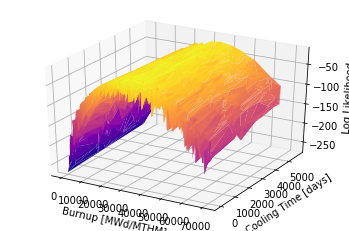

In [20]:
x = trainXY['Burnup']
y = trainXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = trainXY['LogLikelihood']

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap=plt.cm.plasma)
ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(12398, 16)

In [24]:
mod = NormMod(y, X)

In [25]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 2040419.517299
         Iterations: 5464
         Function evaluations: 7309
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -2.5297e+10
Model:                        NormMod   AIC:                         5.059e+10
Method:            Maximum Likelihood   BIC:                         5.059e+10
Date:                Tue, 20 Aug 2019                                         
Time:                        13:00:39                                         
No. Observations:               12398                                         
Df Residuals:                   12382                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------